I am heavily referring to https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8 for this notebook.
Using KerasCNN, model adapted from https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import platform
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


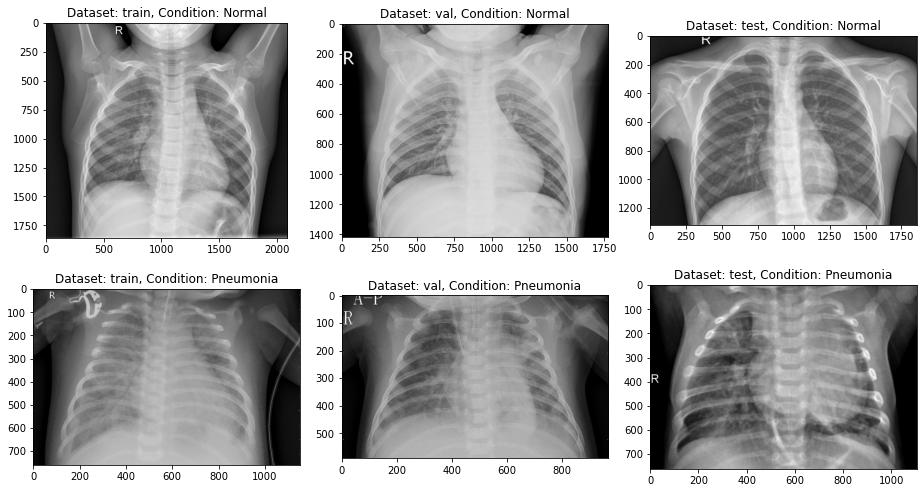

In [2]:
### System Settings ###
pdiv = "/" if platform.system() == "Windows" else "\\"

### Visualising the Dataset ###
fig, ax = plt.subplots(2, 3, figsize=(13, 7))
ax = ax.ravel()
plt.tight_layout()
path = ".{}chest_xray{}".format(pdiv,pdiv)


## We Grayscale the images to better spot the differences ###
for i, _set in enumerate(['train', 'val', 'test']):
    ax[i].imshow(plt.imread(path+_set+pdiv+'NORMAL'+pdiv+os.listdir(path+_set+pdiv+'NORMAL')[0]), cmap='gray')
    ax[i].set_title('Dataset: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(path+_set+pdiv+'PNEUMONIA'+pdiv+os.listdir(path+_set+pdiv+'PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Dataset: {}, Condition: Pneumonia'.format(_set))

It is evident that the differences between a "Normal" and a "Pneumonia" chest-X-ray are highly similar, with the differences being very difficult to identify. A professional trained Radiologist takes anywhere from 15 minutes to an hour to identify and classify the patients into either "Normal" or "Pneumonia"

In [3]:
### Inspecting the Dataset ###

for _dataset in ['train', 'val', 'test']:
    num_normal = len(os.listdir(path + _dataset + '/NORMAL'))
    num_pneu = len(os.listdir(path + _dataset + '/PNEUMONIA'))
    print('Set: {}, No. of Normal Images: {}, No. of Pneumonia images: {}'.format(_dataset, num_normal, num_pneu))

Set: train, No. of Normal Images: 1341, No. of Pneumonia images: 3875
Set: val, No. of Normal Images: 8, No. of Pneumonia images: 8
Set: test, No. of Normal Images: 234, No. of Pneumonia images: 390


We observe that the number of Normal images are far fewer than the number of Pneumonia images in the training set. This means that we have to create our own data, or data augmentation to produce more training data.

In [4]:
### Data Augmentation/Generation ##
def data_gen(img_height, img_width, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, rotation_range=20, brightness_range=(1.1,1.3))
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        directory = path+'train',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    val_gen = val_datagen.flow_from_directory(
        directory = path+'val',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    test_gen = test_datagen.flow_from_directory(
        directory = path+'test',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    new_test_data = []
    new_test_labels = []
    
    normal = '{}NORMAL{}'.format(pdiv,pdiv)
    pneumonia = '{}PNEUMONIA{}'.format(pdiv,pdiv)
    
    for cond in [normal, pneumonia]:
        for img in (os.listdir(path+'test'+cond)):
            img = plt.imread(path+'test'+cond+img)
            img = cv2.resize(img, (img_height, img_width))
            img = np.dstack([img, img, img])
            img = img.astype(np.float32)/255
            if cond == normal:
                label = 0
            else:
                label = 1
            new_test_data.append(img)
            new_test_labels.append(label)
            
    new_test_data = np.array(new_test_data)
    new_test_labels = np.array(new_test_labels)
    
    return train_gen, val_gen, test_gen, new_test_data, new_test_labels

In [ ]:
### TODO: Create Class Labels for images ###

In [5]:
img_height = 224
img_width = 224
batch_size = 32
num_epochs = 10

train_gen, val_gen, test_gen, new_test_data, new_test_labels = data_gen(img_height, img_width, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
### Building the Model ###
def model_builder_kcnn():
    input_img = Input(shape=(img_height, img_width, 3))
    
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(input_img)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = SeparableConv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x) #to reduce overfitting
    
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
### Training the model ###
model_kcnn = model_builder_kcnn()
model_kcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#To reduce overfitting, have callbacks
checkpt = ModelCheckpoint(filepath='best_model_time', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(patience=2)


trained_model = model_kcnn.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples//batch_size, 
           epochs=num_epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples//batch_size, callbacks=[checkpt, early_stop])

Epoch 1/10
163/163 [==============================] - 849s 5s/step - loss: 0.3199 - accuracy: 0.8606 - val_loss: 2.2106 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 924s 6s/step - loss: 0.2134 - accuracy: 0.9164 - val_loss: 1.3766 - val_accuracy: 0.5000
Epoch 3/10
142/163 [=========================>....] - ETA: 2:00 - loss: 0.1779 - accuracy: 0.9351

To check how good our trained model is, we will check the Recall and Precision of our model

$Recall = \frac{True Positives}{True Positives + False Negatives}$

$Precision = \frac{True Positives}{True Positives + False Positives}$

For predicting pneumonia, we should aim to maximise Recall as the complications caused by incorrectly classifying a pneumonia case as a normal case is much more deadly than a normal case being classified as a pneumonia case. With the former being possibly deadly to the incorrectly labelled individual while the latter will soon be spotted by medical staff and corrected.

Plot the Confusion Matrix to calculate the Recall and the Precision